<a href="https://colab.research.google.com/github/muhamrii/RANCapacityPlanning/blob/main/ClusterSiteConfig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
# Load dataset
data = pd.read_csv("data_all.csv")

# Define feature columns
numerical_features = []  # Add numerical columns if any
categorical_features = ["ENM", "BBTYPE", "RADIOTYPE", "LTE_TECH", "TRX Config", "NR_TECH"]

In [8]:
# Fill missing values
for col in categorical_features:
    data[col] = data[col].fillna("Unknown")

# Preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop')

# Preprocess the data
processed_data = preprocessor.fit_transform(data)

In [9]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=20)
reduced_data = pca.fit_transform(processed_data)

# Define the autoencoder
input_dim = reduced_data.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(10, activation='relu')(input_layer)
encoded = Dense(5, activation='relu')(encoded)
decoded = Dense(10, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Build the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile and train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(reduced_data, reduced_data, epochs=50, batch_size=32, shuffle=True, verbose=1)

# Get encoded representations
encoded_data = encoder.predict(reduced_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_data)

# Add cluster labels to the original data
data['Cluster'] = clusters

Epoch 1/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2278
Epoch 2/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0993
Epoch 3/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0890
Epoch 4/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0859
Epoch 5/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0856
Epoch 6/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0851
Epoch 7/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0845
Epoch 8/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0840
Epoch 9/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0841
Epoch 10/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0841
Epoch 11/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0825
Epoch 12/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0817
Epoch 13/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0808
Epoch 14/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0810
Epoch 15/50
795/795 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - lo

In [10]:
# Evaluate clustering performance
silhouette_avg = silhouette_score(encoded_data, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Save clustered data
data.to_csv("clustered_data.csv", index=False)

print("Clustering complete. Results saved to clustered_data.csv.")

Silhouette Score: 0.5131372809410095
Clustering complete. Results saved to clustered_data.csv.


In [11]:
import matplotlib.pyplot as plt

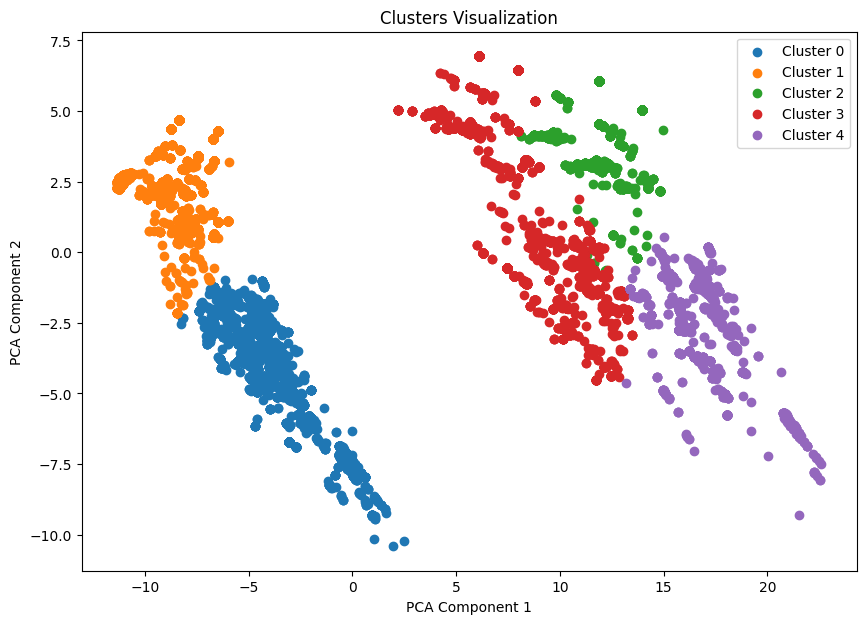

In [12]:
# Visualize clustering results in 2D
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(encoded_data)

plt.figure(figsize=(10, 7))
for cluster in np.unique(clusters):
    plt.scatter(reduced_2d[clusters == cluster, 0], reduced_2d[clusters == cluster, 1], label=f"Cluster {cluster}")
plt.title("Clusters Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()



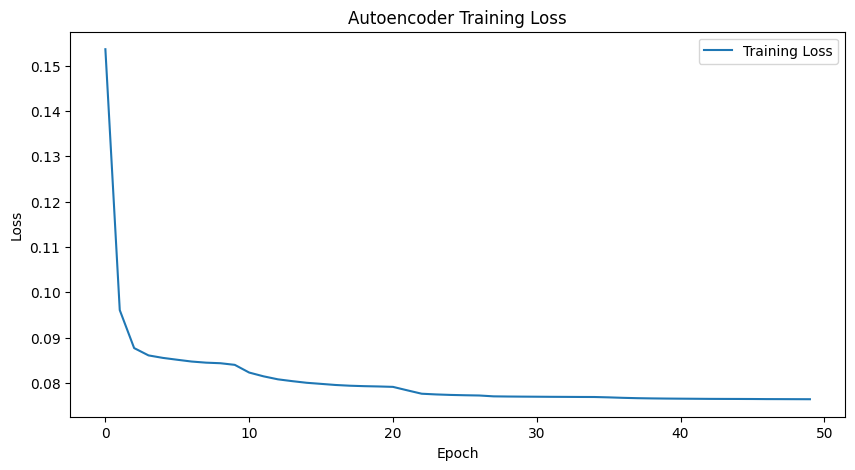

Clustering complete. Results saved to clustered_data.csv.


In [13]:
# Visualize training loss
plt.figure(figsize=(10, 5))
history = autoencoder.history.history
plt.plot(history['loss'], label="Training Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("Clustering complete. Results saved to clustered_data.csv.")

In [16]:
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree

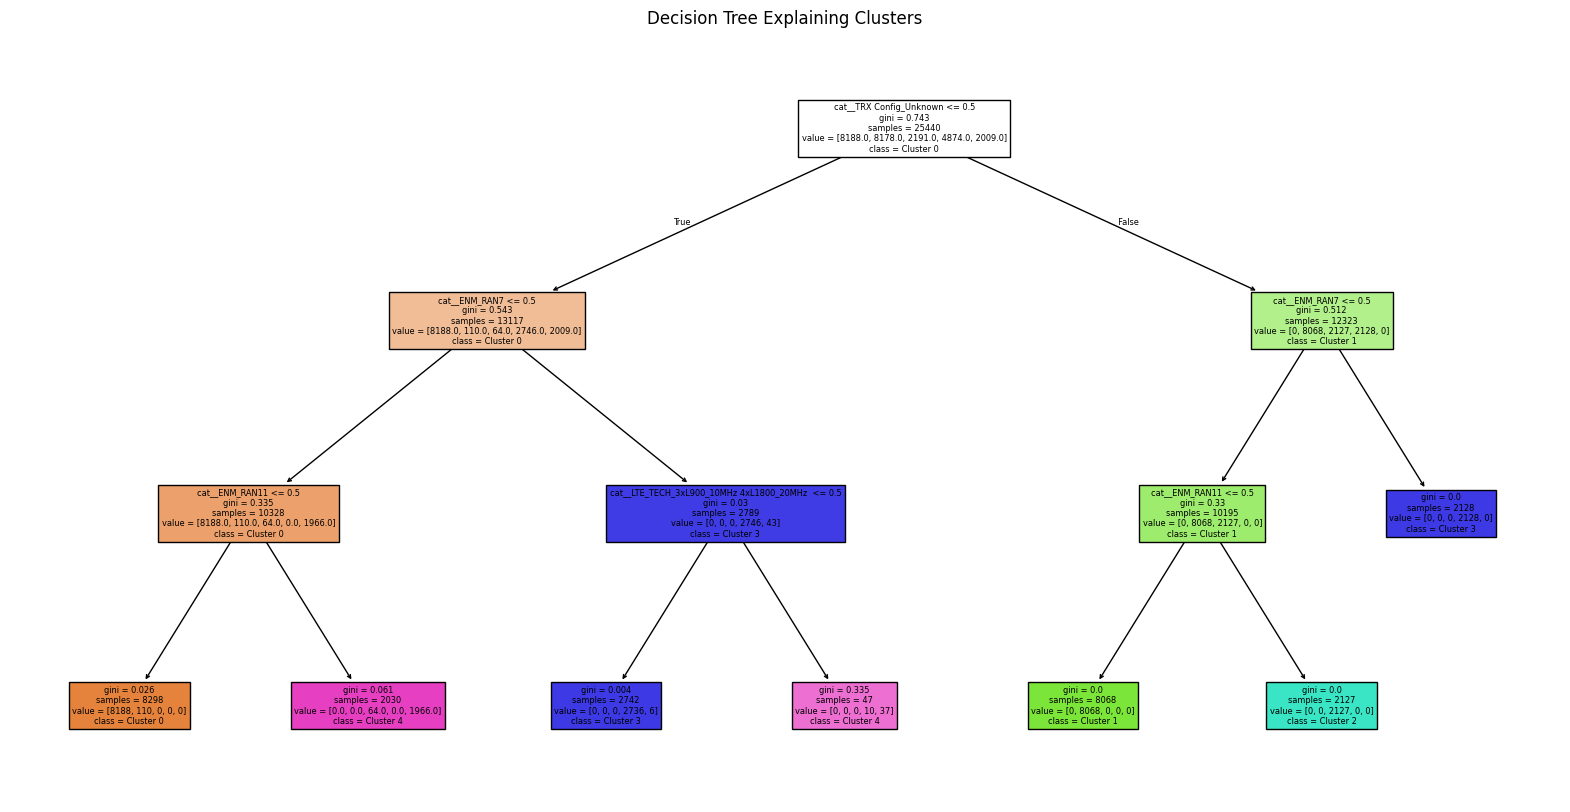

In [23]:
# Visualize how clusters are formed using a decision tree
X_features = processed_data  # Use the original processed features
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_features, clusters)

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=preprocessor.get_feature_names_out(), class_names=[f"Cluster {i}" for i in range(5)], filled=True)
plt.title("Decision Tree Explaining Clusters")
plt.show()



The decision tree visualization provides insight into how the features contribute to the formation of the clusters. Here's a breakdown of the tree's structure:

1. **Root Node**:
   - The tree starts by evaluating a feature derived from the preprocessed data (`cat_ENM_RAN7`).
   - This feature represents a specific encoding of the `ENM` (ENM Location) variable.
   - The Gini impurity at this node is calculated, representing the diversity of clusters at this point.

2. **First Split**:
   - If `cat_ENM_RAN7` is less than or equal to 0.5, the data is sent to the left child node.
   - Otherwise, it goes to the right child node.
   - This split attempts to separate sites into distinct clusters based on the encoded ENM location.

3. **Subsequent Splits**:
   - At each child node, the decision tree selects the next most important feature for further splits. For example:
     - At one node, `cat_LTE_TECH` (LTE technology configuration) is evaluated.
     - At another node, `cat_TRX_Config_Unknown` (whether the 2G TRX configuration is unknown) is used.
   - These features are chosen based on how well they separate clusters.

4. **Leaf Nodes**:
   - The leaf nodes represent the final clusters (e.g., Cluster 0, Cluster 1, etc.).
   - Each leaf shows the number of samples belonging to the cluster and their proportion.

5. **Interpretation of Gini Values**:
   - Lower Gini values indicate purer splits, meaning that a node primarily contains samples from one cluster.
   - Higher Gini values indicate more mixed clusters at that node.

6. **Insights**:
   - The tree shows which features are most relevant for distinguishing between clusters. For example:
     - The feature `cat_ENM_RAN7` is the most significant for the first split.
     - Features like `cat_LTE_TECH` and `cat_TRX_Config` also contribute significantly to clustering decisions.

This tree provides a clear explanation of how the clustering model leverages the feature set to form distinct groups. The visualization can also help identify which features are driving the clustering process and their relative importance.

Would you like to further refine the tree or adjust its depth to make the splits more detailed?

<ipython-input-18-4da6befe0d62>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Cluster'], palette="viridis")


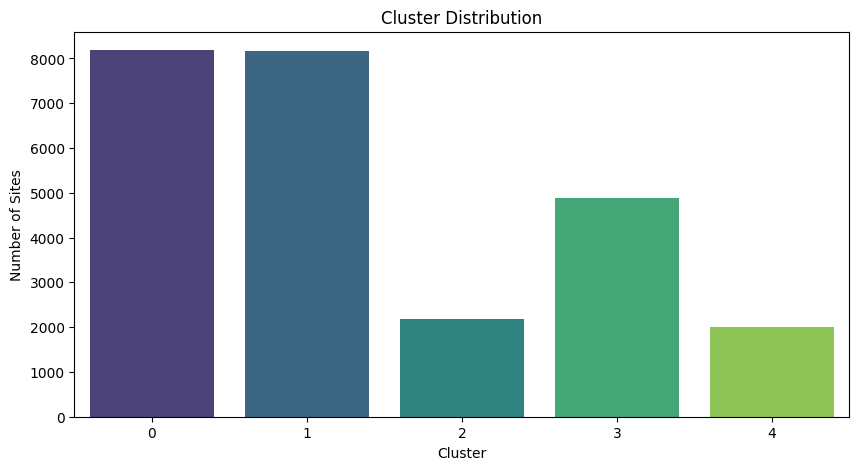

Clustering complete. Results saved to clustered_data.csv.


In [18]:
# Visualize the distribution of clusters
plt.figure(figsize=(10, 5))
sns.countplot(x=data['Cluster'], palette="viridis")
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Sites")
plt.show()

print("Clustering complete. Results saved to clustered_data.csv.")

In [19]:
from pandas.plotting import parallel_coordinates
from math import pi

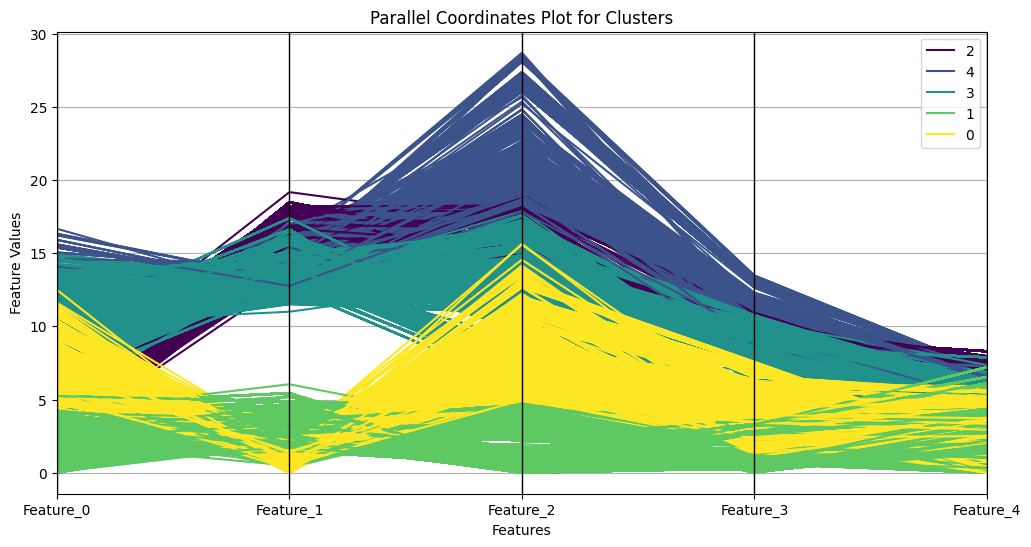

In [24]:
# Parallel Coordinates Plot
encoded_df = pd.DataFrame(encoded_data, columns=[f"Feature_{i}" for i in range(encoded_data.shape[1])])
encoded_df['Cluster'] = clusters

plt.figure(figsize=(12, 6))
parallel_coordinates(encoded_df, class_column='Cluster', colormap='viridis')
plt.title("Parallel Coordinates Plot for Clusters")
plt.xlabel("Features")
plt.ylabel("Feature Values")
plt.show()

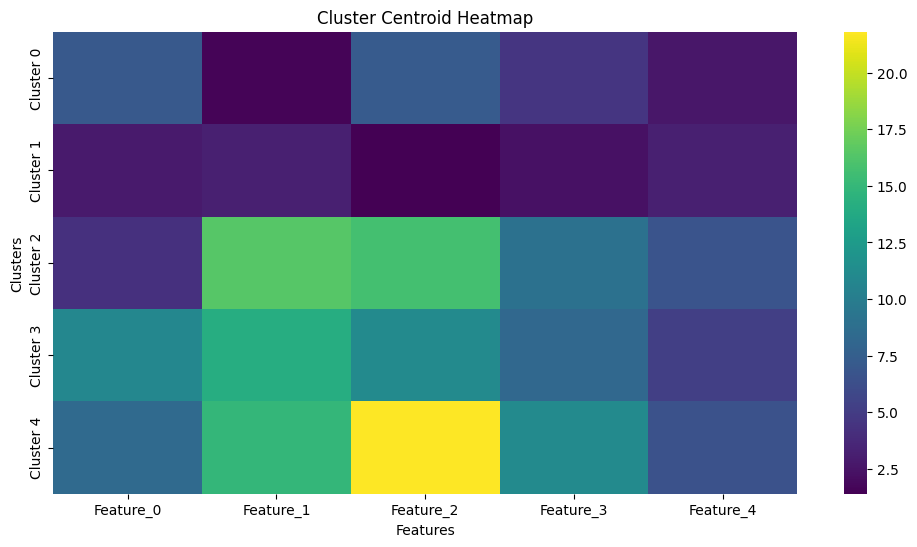

In [25]:
# Cluster Centroid Heatmap
centroids = kmeans.cluster_centers_

plt.figure(figsize=(12, 6))
sns.heatmap(centroids, cmap="viridis", annot=False, cbar=True, xticklabels=[f"Feature_{i}" for i in range(encoded_data.shape[1])], yticklabels=[f"Cluster {i}" for i in range(5)])
plt.title("Cluster Centroid Heatmap")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()

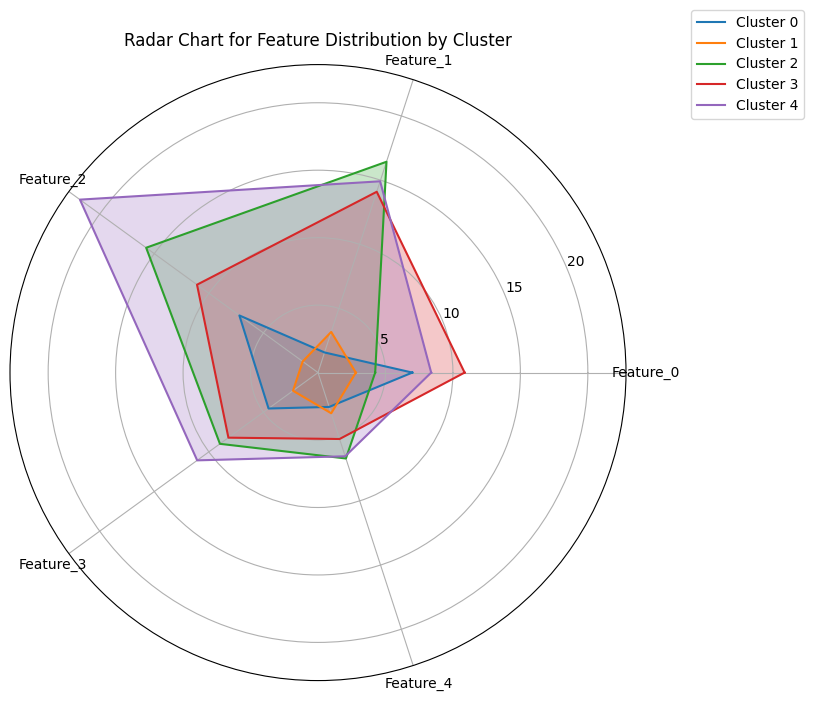

In [27]:
# Radar Chart for Feature Distribution
num_features = encoded_data.shape[1]
angles = [n / float(num_features) * 2 * pi for n in range(num_features)]
angles += angles[:1]  # Close the circle

plt.figure(figsize=(8, 8))

for cluster in range(5):  # Number of clusters
    values = centroids[cluster].tolist()
    values += values[:1]  # Close the circle

    plt.polar(angles, values, label=f"Cluster {cluster}")
    plt.fill(angles, values, alpha=0.25)

plt.title("Radar Chart for Feature Distribution by Cluster")
plt.xticks(angles[:-1], [f"Feature_{i}" for i in range(num_features)])
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()